### Первый вариант решения задачи
Произведя анализ данных определил, что в полях price, number_of_reviews, reviews_per_month пресутсивуют выбросы. Также в поле reviews_per_month есть пустые значения. Создав модель на основе данных без выбросов и пустых значений, получил очень низкую дисперсию.
Добавив новые поле Манхэттенское расстояние ничего не изменилось. После добавления новых полей days_since_review, revenues метрики оценки качества сали намного лучше:
- RMSE: 32.40 - ошибка 29% (много)
- MAE: 24.5437
- R2 Score: 0.68

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

file_path = "AB_NYC_2019.csv"
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "dgomonov/new-york-city-airbnb-open-data", file_path)

df.head()

/tmp/ipykernel_18735/3320586153.py:9: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "dgomonov/new-york-city-airbnb-open-data", file_path)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [720]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:
from datetime import datetime
numerical_cols = [ 'minimum_nights', 
                 'number_of_reviews', 'reviews_per_month', 
                 'calculated_host_listings_count', 'availability_365', 'days_since_review', 'revenues' ] # 'latitude', 'longitude'. manhattan_distance
categorical_features = ['room_type', 'neighbourhood', 'neighbourhood_group'] # 


# Координаты Manhattan (опорная точка)
# manhattan_lat = 40.776676
# manhattan_lon = -73.971321

# Вычисляем Манхэттенское расстояние (разница по широте + разница по долготе)
# df['manhattan_distance'] = (
#     abs(df['latitude'] - manhattan_lat) + 
#     abs(df['longitude'] - manhattan_lon)
# )

df = df[df['price'].between(0, 260)]

df = df[df['number_of_reviews']<200]
df = df[df['reviews_per_month']<13]

# Доходы
df['revenues'] = df['price'] * df['availability_365']

current_date = datetime.now()
df['last_review'] = pd.to_datetime(df['last_review'])
df['days_since_review'] = (current_date - df['last_review']).dt.days


columns_to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review', 'latitude', 'longitude']

df.drop(columns=columns_to_drop, axis=1, inplace=True)
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
revenues                          0
days_since_review                 0
dtype: int64

In [722]:
df.head(10)

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,revenues,days_since_review
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365,54385,2447
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355,79875,2233
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0,0,2416
5,Manhattan,Murray Hill,Entire home/apt,200,3,74,0.59,1,129,25800,2201
6,Brooklyn,Bedford-Stuyvesant,Private room,60,45,49,0.40,1,0,0,2826
8,Manhattan,Upper West Side,Private room,79,2,118,0.99,1,0,0,2902
9,Manhattan,Chinatown,Entire home/apt,150,1,160,1.33,4,188,28200,2214
10,Manhattan,Upper West Side,Entire home/apt,135,5,53,0.43,1,6,810,2201
11,Manhattan,Hell's Kitchen,Private room,85,2,188,1.50,1,39,3315,2200
12,Brooklyn,South Slope,Private room,89,4,167,1.34,3,314,27946,2199


In [723]:
df.fillna({'reviews_per_month':0}, inplace=True)
df.reviews_per_month.isnull().sum()

0

In [724]:
df.neighbourhood_group.unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [725]:
df.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

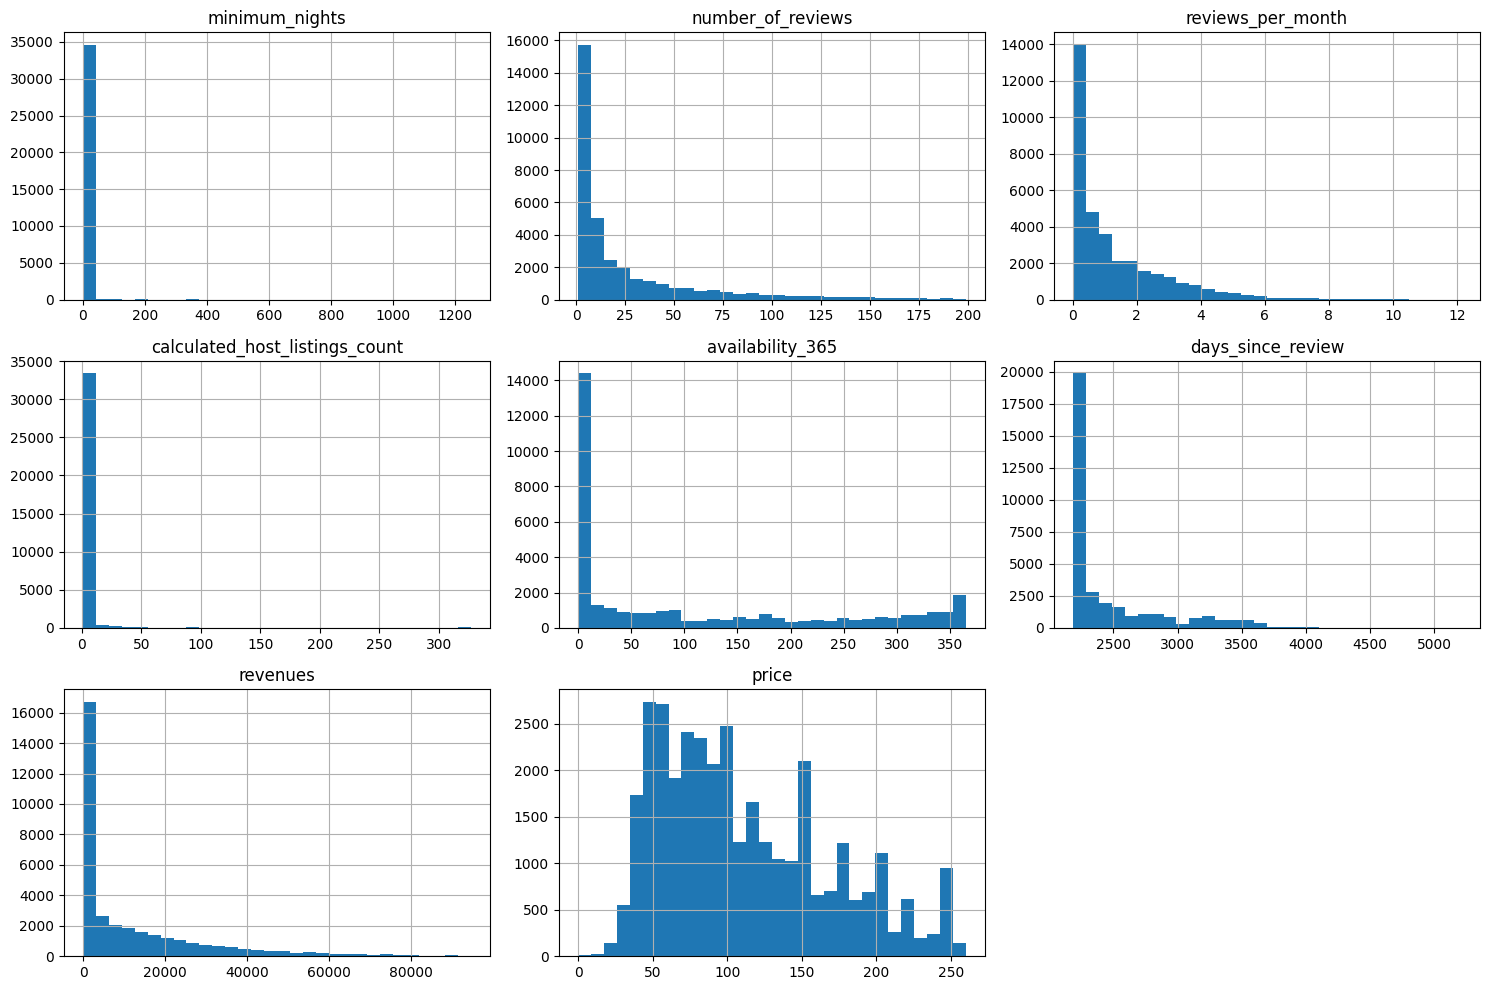

In [726]:
num_cols = numerical_cols + ['price']
df[num_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

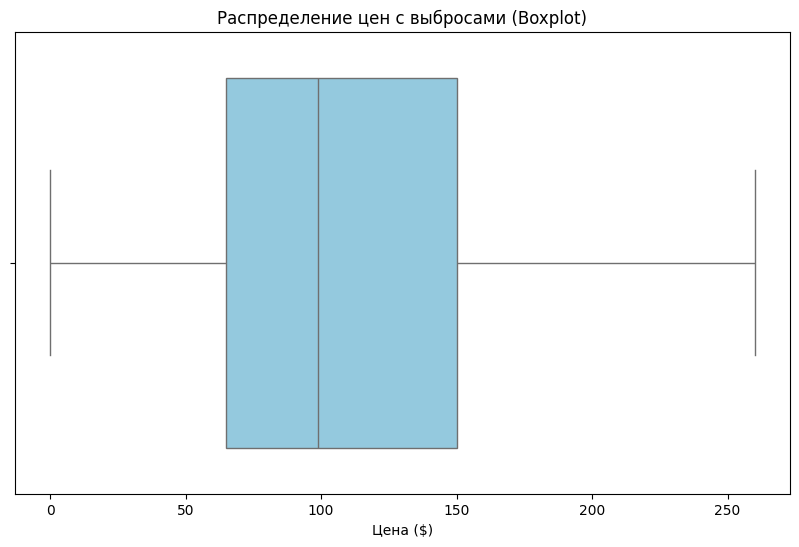

In [727]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'], color='skyblue')
plt.title('Распределение цен с выбросами (Boxplot)')
plt.xlabel('Цена ($)')
plt.show()

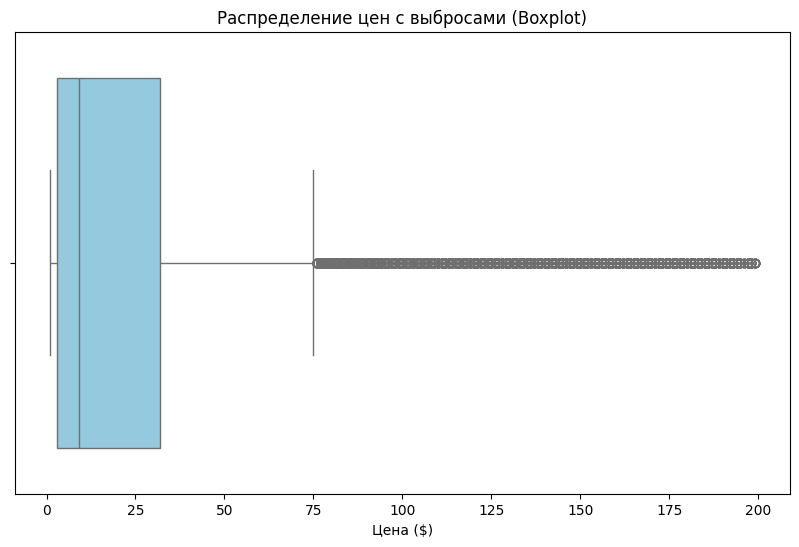

In [728]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['number_of_reviews'], color='skyblue')
plt.title('Распределение цен с выбросами (Boxplot)')
plt.xlabel('Цена ($)')
plt.show()

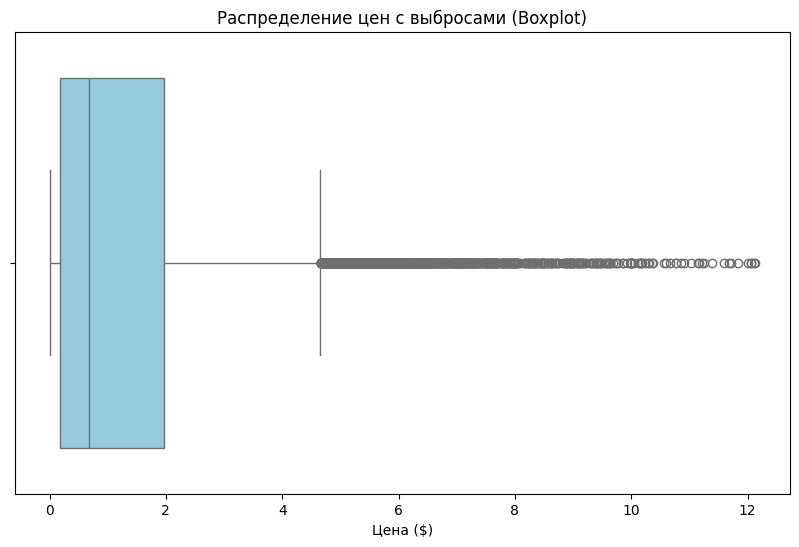

In [729]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['reviews_per_month'], color='skyblue')
plt.title('Распределение цен с выбросами (Boxplot)')
plt.xlabel('Цена ($)')
plt.show()

In [730]:
top_prices = df['price'].sort_values(ascending=False).head(10)
print(top_prices)

17064    260
45578    260
31594    260
33885    260
29300    260
37246    260
6762     260
37247    260
42402    260
42334    260
Name: price, dtype: int64


In [731]:
print("Перцентили цен:")
print(df['price'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

Перцентили цен:
count    34824.000000
mean       111.066391
std         57.085139
min          0.000000
25%         65.000000
50%         99.000000
75%        150.000000
90%        200.000000
95%        225.000000
99%        250.000000
max        260.000000
Name: price, dtype: float64


In [732]:
zero_price_count = len(df[df['price'] == 0])

# Выводим результат
print(f"Количество строк с price = 0: {zero_price_count}")

Количество строк с price = 0: 10


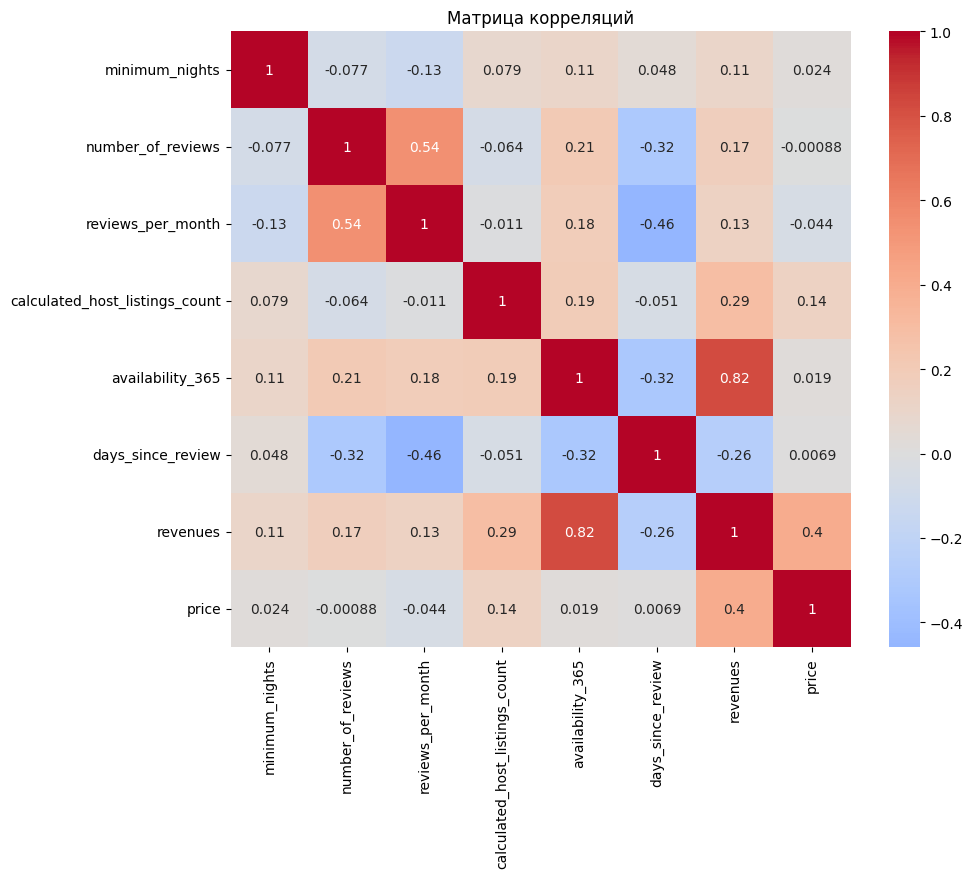

In [733]:
# Вычисляем корреляцию
corr_matrix = df[numerical_cols + ['price']].corr()

# Тепловая карта
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

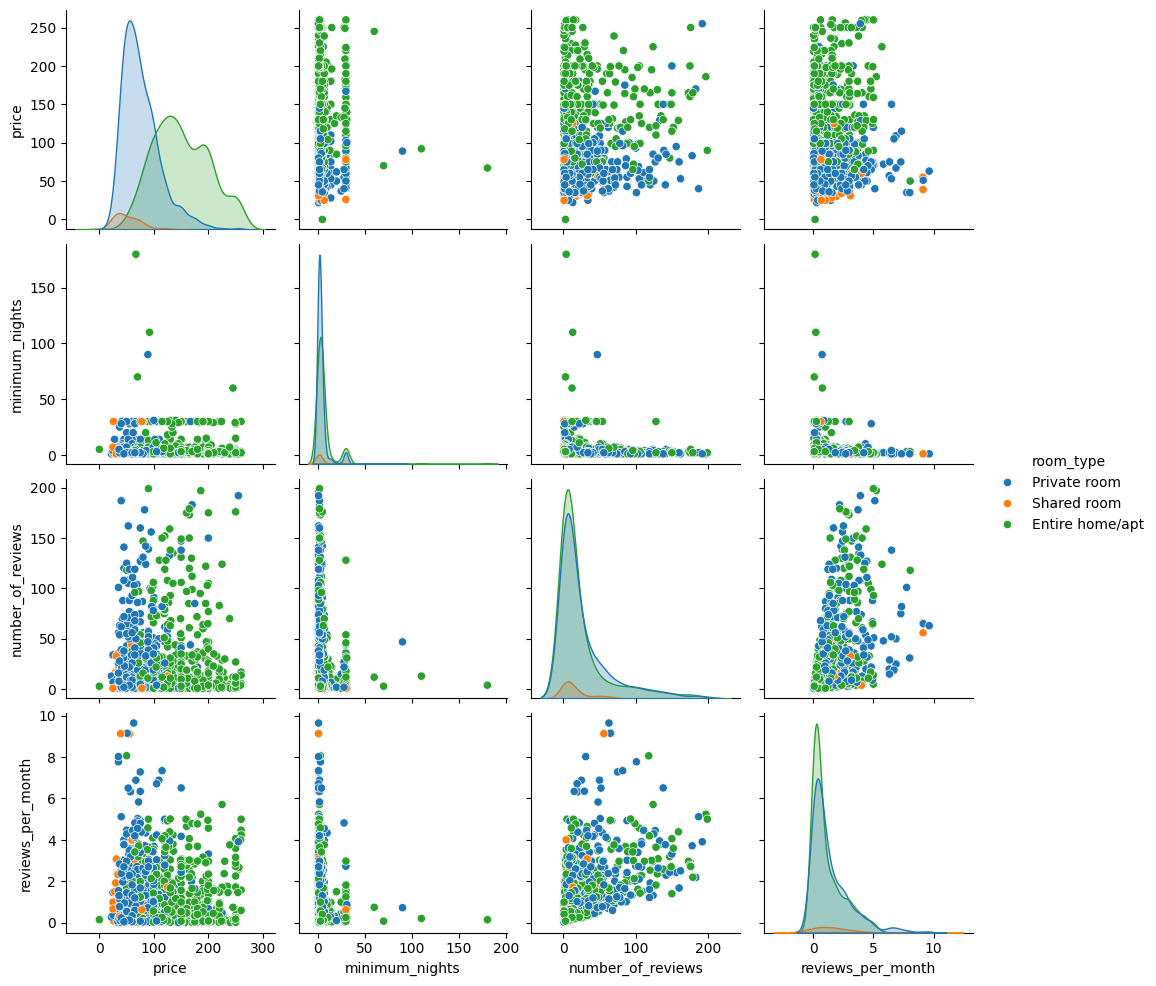

In [734]:
sample_df = df.sample(1000)

sns.pairplot(sample_df[['price', 'minimum_nights', 'number_of_reviews', 
                       'reviews_per_month', 'room_type']], 
             hue='room_type', diag_kind='kde')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

numerical_features = numerical_cols

X = df.drop(columns=['price'])  # Признаки
y = df['price']  # Целевая переменная (цена)

In [736]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [737]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [738]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = pipeline.predict(X_test)

In [739]:
# Метрики
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f"MAE: {mae:.4f}")
print(f'R2 Score: {r2:.2f}')

RMSE: 32.40
MAE: 24.5437
R2 Score: 0.68


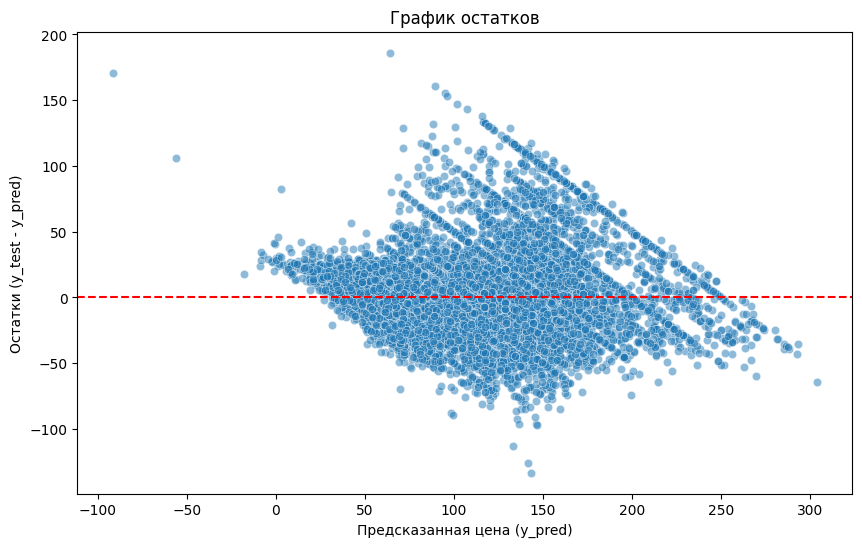

In [740]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанная цена (y_pred)')
plt.ylabel('Остатки (y_test - y_pred)')
plt.title('График остатков')
plt.show()

In [741]:
print(f"Средняя цена: {df['price'].mean():.2f}$")

Средняя цена: 111.07$


In [747]:
from sklearn.linear_model import RidgeCV

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Подбор alpha с кросс-валидацией (по умолчанию 5-fold CV)
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train_processed, y_train)

# Предсказание
y_pred_ridge = ridge.predict(X_test_processed)

# Оценка качества
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("\nRidgeCV:")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2_ridge:.2f}")


RidgeCV:
RMSE: 32.34
R2: 0.68


In [ ]:
from sklearn.linear_model import LassoCV

# Подбор alpha с кросс-валидацией (увеличиваем max_iter для сходимости)
lasso = LassoCV(alphas=np.logspace(-3, 3, 100), cv=5, max_iter=10000)
lasso.fit(X_train_processed, y_train)

# Предсказание
y_pred_lasso = lasso.predict(X_test_processed)

# Оценка качества
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("\nLassoCV:")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2_lasso:.2f}")


LassoCV:
MSE: 32.33
R2: 0.68
